In [1]:
from data_generator import dataGenerator2d
from variableSelection import evaluationExperiment
from functionTree import kdTree, rpTree, honestTree, classifcationTree, miStagewise
from baseline_models import forward_selection

import matplotlib.pyplot as plt
import numpy as np

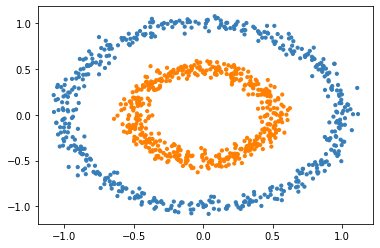

In [2]:
x, y = dataGenerator2d(n=1000, irr=0).fit()
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(x['X0'], x['X1'], s=10, color=colors[y])

In [9]:
Rep=3
model_dic = {'rp': rpTree(Rep=Rep),
            'kd': kdTree(Rep=Rep),
            'classification': classifcationTree(Rep=1),
            'honest': honestTree(Rep=Rep),
            'mi': miStagewise(Rep=1),
            'linear': forward_selection}
size = [20, 50, 100, 500, 1000]
exp1 = evaluationExperiment(size=[20], model_dic = model_dic, dataGenerator=dataGenerator2d, rr=2, irr=48, verbose=True, data_rep=15)

In [10]:
exp1.run()

Sample size: 20
Time(s): 102.828842901


{20: {'rp': {'scores': [14.166666666666666,
    16.379430945988997,
    14.166666666666666,
    13.033064273553082,
    14.166666666666666,
    14.166666666666666,
    13.033064273553082,
    14.166666666666666,
    16.379430945988997,
    14.166666666666666,
    13.033064273553082,
    14.166666666666666,
    14.166666666666666,
    13.033064273553082,
    14.166666666666666],
   'variables': [['X38'],
    ['X16'],
    ['X30', 'X43', 'X11'],
    ['X2', 'X10'],
    ['X10', 'X47', 'X18'],
    ['X39'],
    ['X38', 'X19', 'X28'],
    ['X1', 'X18'],
    ['X13'],
    ['X32'],
    ['X25', 'X43'],
    ['X42'],
    ['X13', 'X16', 'X18'],
    ['X2', 'X23'],
    ['X19', 'X18']],
   'accuracy': [0.94,
    0.94,
    0.9,
    0.92,
    0.9,
    0.94,
    0.9,
    0.96,
    0.94,
    0.94,
    0.92,
    0.94,
    0.9,
    0.92,
    0.92],
   'recall': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.5,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0],
   'precision': [

In [11]:
exp1.summary()[20]

,scores,variables,accuracy,recall,precision,f1
rp,14.159408,"[[X38], [X16], [X30, X43, X11], [X2, X10], [X1...",0.925333,0.033333,0.033333,0.033333
kd,14.925097,"[[X38], [X16], [X30, X8], [X2], [X22], [X39], ...",0.929333,0.000000,0.000000,0.000000
classification,11.652686,"[[X38, X33], [X3, X25, X42], [X28, X6], [X13, ...",0.925333,0.133333,0.111111,0.120000
honest,8.675931,"[[X4], [X31], [X24, X32], [X32, X13, X31], [X4...",0.928000,0.000000,0.000000,0.000000
mi,0.794651,"[[X21, X44, X5], [X3, X8], [X36, X41], [X36, X...",0.926667,0.166667,0.213333,0.174603
linear,5.292460,"[[X19, X3, X34], [X17, X18, X2, X31], [X20, X4...",0.889333,0.000000,0.000000,0.000000


In [1]:
from data_generator import rvs2d

from functionTree import kdTree, rpTree, classifcationTree, honestTree, miStagewise
from baseline_models import forward_selection
from variableSelection import evaluationExperiment
test1_predictors, test1_targets = rvs2d(n=100, irr=98)

In [2]:
Rep = 3
model_dic = {'rp': rpTree(Rep=Rep),
            'kd': kdTree(Rep=Rep),
            'classification': classifcationTree(Rep=1),
            'honest': honestTree(Rep=Rep),
            'mi': miStagewise(Rep=1),
            'linear': forward_selection}
size = [20, 50, 100, 500, 1000]
exp1 = evaluationExperiment(size=[20], model_dic=model_dic, dataGenerator=rvs2d, rr=2, irr=48, verbose=True, data_rep=15)

In [25]:
dt.make_multilabel_classification(n_samples=10)


(array([[5., 2., 3., 2., 3., 5., 1., 6., 1., 3., 2., 1., 3., 0., 0., 2.,
         2., 2., 0., 0.],
        [3., 1., 3., 2., 2., 3., 1., 3., 1., 4., 4., 3., 3., 3., 3., 2.,
         3., 1., 1., 2.],
        [3., 4., 0., 3., 1., 5., 3., 1., 0., 3., 3., 0., 3., 2., 3., 5.,
         1., 2., 1., 3.],
        [2., 4., 4., 2., 1., 3., 0., 1., 1., 2., 1., 4., 1., 2., 2., 1.,
         6., 2., 1., 4.],
        [6., 0., 1., 2., 3., 5., 3., 7., 3., 4., 1., 2., 2., 3., 3., 3.,
         2., 4., 5., 1.],
        [4., 2., 1., 1., 1., 4., 2., 7., 2., 3., 2., 3., 3., 0., 2., 0.,
         1., 0., 2., 1.],
        [2., 1., 2., 1., 3., 4., 2., 2., 4., 7., 1., 4., 2., 3., 1., 4.,
         1., 0., 1., 4.],
        [2., 0., 4., 4., 1., 2., 5., 5., 3., 1., 4., 7., 1., 2., 2., 2.,
         0., 1., 2., 3.],
        [7., 2., 0., 6., 2., 2., 2., 6., 2., 3., 1., 0., 2., 1., 2., 2.,
         1., 4., 2., 4.],
        [3., 1., 5., 4., 2., 3., 2., 1., 3., 3., 1., 6., 2., 1., 3., 1.,
         1., 4., 0., 3.]]),
 array([